# Introduction to Neuroinformatics
## Exercise session 2: Passive Membrane Potential

Welcome to the first exercise session of the introduction to neuroinformatics course. This exercise session will visualize various membrane potential equations for you to interact with and answer assignments. Later in the notebook, we will move to some theory involving RC circuits.

# Table of contents
* [Packages](#packages)
* [1. Introduction to passive membrane properties](#intro)
    * [1.1: Nernst Equation](#Neq)
    * [1.2: Nernst-Planck Equation](#NPeq)
    * [1.3: Goldman-Hodgkin-Katz (GHK) Equation](#GHK)
* [2. Membrane Capacitance and the RC Circuit](#modelling)
    * [2.1: Series Circuit Analyis](#series)
    * [2.2: Charing and discharging in the series RC circuit](#charging)
    * [2.3: The time constant Tau](#tau)

# Packages <a class="anchor" id="packages"></a>
We <font color='red'>**highly recommend**</font> to download this notebook and run it <font color='red'>**locally**</font> on your machine. The interactive plots are slow in Google Colab and don't provide a nice experience.

If you wish to continue in Colab, click on the "Copy to Drive" button to be able to save your progress.

The following cells are used to install the necessary packages and libraries for the exercise:

In [1]:
!which python  # This displays which python is being used
!pwd # This displays the current directory

/usr/local/bin/python
/content


In [ ]:
!pip install --quiet scipy PyQt6 ipywidgets wget

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import R, physical_constants

In [ ]:
import wget
import os

# Define the URL and the output directory
url = 'https://github.com/ManteLab/Iton_notebooks_public/raw/refs/heads/main/utils_ex1/utils.py'
output_dir = 'utils_ex1'

if not os.path.exists(output_dir):
    # Create the directory if it doesn't already exist
    os.makedirs(output_dir, exist_ok=True)

    # Download the file into the specified directory
    print(f"Downloading file to '{output_dir}'...")
    filename = wget.download(url, out=output_dir)
    print(f"\nFile successfully downloaded as: {filename}")

Checking the platform:

In [ ]:
platform = 'notebook'
try:
    import google.colab
    platform = 'colab'
except:
    pass
print(f"platform: {platform}")

platform: colab


In [ ]:
if platform == 'colab':
    !pip3 install --quiet ipympl
    from google.colab import output
    output.enable_custom_widget_manager()
else:
    %matplotlib notebook


In [ ]:
from utils_ex1.utils import nernst_interactive_plot, nernst_planck_interactive_plot, ghk_interactive_plot

# Faraday constant (F) from scipy's physical_constants
F_constant = physical_constants['Faraday constant'][0]

# Define constants
T_default = 310  # Temperature in Kelvin (37°C, human body temperature)
R_constant = R  # Universal gas constant in J/(mol·K)

---

# 1. Introduction to passive membrane properties <a name="intro"></a>
In the previous exercise you became familiar with Jupyter Notebooks. This should help you to navigate this and all upcoming exercises.

This Notebook contains Exercise 2 and offers a partial review of concepts covered in the last lecture. Additionally, it introduces new aspects that demonstrate neuronal passive membrane properties, while also explaining the mathematical principles used to model these properties.

You will encouter various **tasks** during the exercise marked with the keyword  **"Assignments"**. Try to solve these assignments to the best of your ability - many of your solutions are essential to understand the next parts of the exercise.

**Solutions** to the exercises will be published the following week.

## 1.1: Nernst Equation - Reversal / equilibrium potential <a name="Neq"></a>
You have already heard that positivly and negatively charged ions and their distribution on both sides of the cell membrane are responsible for some of the biophysical properties of neurons.

The Nernst equation calculates the ***equilibrium potential*** (membrane potential at which there is <ins>no net flow</ins> of ions) for a single ion based on its concentration gradient across the membrane and is given by:


$$E_{ion} = \frac{RT}{zF} \ln \left( \frac{[ion]_{out}}{[ion]_{in}} \right)$$
where:
- $E_{ion}$ is the equilibrium potential for the ion, given in V
- $R$ is the universal gas constant (8.314 J/(mol·K))
- $T$ is the temperature in Kelvin
- $z$ is the valence of the ion (e.g., +1 for sodium, +2 for calcium or -1 for chloride)
- $F$ is the Faraday constant (96485 C/mol)
- $[ion]_{out}$ / $[ion]_{in}$ are the extracellular / intracellular concentrations of the ion, given in Mol
- $ln$ is the natural logarithm (base e).


In [ ]:
# Nernst equation function
# This code snippet defines a function to calculate the Nernst potential. It does not affect the exercise below and merely showcases, how the equation could be implemented in the notebook.
def nernst_potential(z, Cin, Cout, T):
    # Parameters handed into the function: z: valence, Cin: intracellular ion concentraion, Cout: extracellular ion concentraion, T: absolute temperature
    return (R_constant * T / (z * F_constant)) * np.log(Cout / Cin) * 1000  # multiplying the results with 1000 returns teh result in mV

In [ ]:
# Visualise the Nernst equation for a given ion
if platform == 'notebook':
    %matplotlib inline
plt.close()
nernst_interactive_plot()

In [ ]:
plt.close()

Above you see a model of a simple neuron and the concentrations of a specific ion (selected by the drop-down menu) inside and outside the cell membrane. Feel free to change some of the parameters using the sliders and observe the change in equilibrium potential (here called Nerst Potential) below the model. Try to answer the following **Assignments**.

---

> **Assignment 1**
>
> Calculate the equilibrium potential for potassium ($K^+$) at 37°C using the Nernst equation when the intracellular concentration of $K^+$ is 140 mM and the extracellular concentration is 5 mM. Then replicate the results using the model above.

Solution:

> **Assignment 2**
>
> How does the calulated Nernst Potential relate to the typical resting membrane potential of a neuron (around -70mV). Why are they not the same?

Solution:

> **Assignment 3**
>
> How does increasing the temperature affect the Nernst potential for sodium ions (Na⁺) when the intracellular concentration is 12 mM and the extracellular concentration is 145 mM. Why do you observe these results?

Solution:

---

## 1.2: Nernst-Planck Equation - Movement of ions across biological membranes

While the ***Nernst equation*** calculates the equilibrium potential for a single ion based <ins>solely on its concentration gradient</ins> (assuming <ins>no net ion flow</ins>), the ***Nernst-Planck equation** extends this concept by <ins>considering the net ionic flux</ins> (ions crossing the membrane) resulting from both a) concentration gradients and b) electric fields. This equation provides a comprehensive description of ion movement across membranes, accounting for diffusion and electromigration under non-equilibrium conditions.

The Nernst-Planck equation is given by:

$$
J_{ion} = -D \left( \frac{d[ion]}{dx} + \frac{z F}{RT} [ion] \frac{dV}{dx} \right)
$$

where:

-	$J_{ion}$ is the ionic flux (mol/(m²·s))
-	$D$ is the diffusion coefficient of the ion (m²/s)
-	$[ion]$ is the concentration of the ion (mol/m³)
-	$x$ is the position across the membrane (m)
- $z$ is the valence of the ion (e.g., +1 for sodium, +2 for calcium or -1 for chloride)
-	$F$ is the Faraday constant (96485 C/mol)
- $R$ is the universal gas constant (8314 J/(mol·K))
- $T$ is the temperature in Kelvin
-	$V$ is the electric potential (V)
-	$\frac{d[ion]}{dx}$ is the concentration gradient
-	$\frac{dV}{dx}$ is the electric potential gradient (electric field)

In [ ]:
# Nerst-Planck equation function
# This code snippet defines a function to calculate Ion flux. It does not affect the exercise below and merely showcases, how the equation could be implemented in the notebook.
def nernst_planck_flux(D_i, C_i, z_i, dVdx, dCdx, T):
    # Parameters handed into the function: D_i: diffusion coefficient, z_i: valence, F_constant: Faraday const., R_constant: Univ. gas const., T: absolute temperature, C_i: ionic concentration, dVdx: electric field
    J_i = -D_i * (dCdx + (z_i * F_constant / (R_constant * T)) * C_i * dVdx)
    return J_i

In [ ]:
if platform == 'notebook':
    %matplotlib inline
plt.close()
nernst_planck_interactive_plot()

Above you see the previous model again. This time, it is set up to calculate the ionic flux of the selected ion, dependent on the ionic concentration, the voltage gradient (membrane potential) and the absolute temperature. When adjusting the parameters, note how the flux (arrow across the membrane) can change direction from in->out to out->in and vice versa. Try to solve the following **Assignments**.

---

>**Assignment 4**
>
> In the plot above, the extracellular potential is 0 mV by default. Set the membrane potential (V_mem) to -70 mV, adjust the extracellular K⁺ concentration to be equal to the intracellular K⁺ concentration. What happens to the flux of K⁺ ions? Explain the oberved behaviour.

Solution:

>**Assignment 5**
>
> Using the Nernst-Planck equation (shown above), derive the condition under which there is zero net flux of an ion across a membrane and compare the newly derived equation to the Nernst equation. See any differences?

Solution:

---

## 1.3 The Goldman-Hodgkin-Katz (GHK) Equation - One ion isn't enough <a name="GHK"></a>
Until now, we <ins>only considered one ion type</ins> at a time. In fact, the membrane potential is established by ***multiple factors***, namely by <ins>various different ion species</ins> as well as the ability of these ions to <ins>cross the membrane</ins>. The **Goldman-Hodgkin-Katz (GHK) equation** is an extension of the Nernst equation that accounts for the permeability of the membrane to these ions.
It calculates the membrane potential based on the relative permeabilities of ions (in this example sodium, potassium, and chloride) as well as their concentration gradients across the membrane.

The GHK equation is given by:

$$V_m = \frac{RT}{F} \ln \left( \frac{P_K[K^+]_{out} + P_{Na}[Na^+]_{out} + P_{Cl}[Cl^-]_{in}}{P_K[K^+]_{in} + P_{Na}[Na^+]_{in} + P_{Cl}[Cl^-]_{out}} \right)$$
where:
- $V_m$ is the membrane potential in mV,
- $R$ is the universal gas constant (8.314 J/(mol·K)),
- $T$ is the temperature in Kelvin,
- $F$ is the Faraday constant (96485 C/mol),
- $P_K$, $P_{Na}$, and $P_{Cl}$ are the permeabilities of potassium, sodium, and chloride ions, respectively,
- $[K^+]_{in}$, $[K^+]_{out}$, $[Na^+]_{in}$, $[Na^+]_{out}$, $[Cl^-]_{in}$, and $[Cl^-]_{out}$ are the intracellular and extracellular concentrations of potassium, sodium, and chloride ions, respectively.
- $ln$ is the natural logarithm (base e).

Note, that the valence $z$ is not found in this equation. Instead, the the inverse of the respective fraction for ions with negative valence is used ($\frac{P[Ion]_{in}}{P[Ion]_{out}}$ instead of $\frac{P[Ion]_{out}}{P[Ion]_{in}}$).

In [ ]:
# Goldman-Hodgkin-Katz equation function
# This code snippet defines a function to calculate the membrane potential given multiple ions. It does not affect the exercise below and merely showcases, how the equation could be implemented in the notebook.
def ghk_potential(PK, PNa, PCl, K_in, K_out, Na_in, Na_out, Cl_in, Cl_out, T):
    num = PK * K_out + PNa * Na_out + PCl * Cl_in # defines the numerator of the fraction used in the GHK equation
    denom = PK * K_in + PNa * Na_in + PCl * Cl_out # defines the denominator of the fraction used in the GHK equation
    return (R_constant * T / F_constant) * np.log(num / denom) * 1000  # in mV

In [ ]:
# GHK equation function interactive plot
if platform == 'notebook':
    %matplotlib inline
plt.close()
ghk_interactive_plot()

In [ ]:
plt.close()

The old-familiar model above now allows you to adjust temerature, ion concentrations as well as the specific permeability for each ion. Based on your selected settings, the membrane potential will change. Try to answer the following **Assignments**.

---

>**Assignment 6**
>
>Using the GHK equation interactive plot above, try to increase the permeability of the membrane to Na⁺ $(P_{Na})$ while keeping other permeabilities and ion concentrations constant, what happens to the membrane potential? Explain your observations.

Solution:

>**Assignment 7**
>
>A neuron is suspect to the following ion concentrations at 37°C:
>
>$ K^+_{in} = 140 \ \text{mM} $
>
>$ K^+_{out} = 5 \ \text{mM} $
>
>$ Na^+_{in} = 15 \ \text{mM} $
>
>$ Na^+_{out} = 145 \ \text{mM} $
>
>$ Cl^-_{in} = 10 \ \text{mM} $
>
>$ Cl^-_{out} = 110 \ \text{mM} $
>
>The membrane permeabilities are: $P_K = 1, P_{Na} = 0.05, \text{and} \ P_{Cl} = 0.45 $ (relative units).
>
>Calculate the membrane potential using the GHK equation.

Solution:

>**Assignment 8**
>
>We consider a neuron with a resting membrane potential of -70 mV. For simplicity, the membrane is selectively permeable only to potassium ($K^+$) and sodium ($Na^{+}$) ions. The equilibrium potential for $K^+$ is -90 mV, and the equilibrium potential for $Na^{+}$ is +60 mV.
>
>- Describe the individual ion fluxes of $K^+$ and $Na^{+}$ across the membrane at resting potential (-70 mV). In which direction is each ion moving and how does each ion's movement relate to its equilibrium potential?
>
>- Explain why there is little to no net ion flux at the resting membrane potential. How do the individual ion fluxes of $K^+$ and $Na^{+}$ contribute to maintaining the resting membrane potential?
>
>- Predict what would happen to the membrane potential if the permeability to $Na^{+}$ increased significantly while the permeability to $K^+$ remained constant.


**1**:

Solution:

**2**:

Solution:

**3**:

Solution:

---


# 2. Membrane Capacitance and the RC Circuit <a name="modelling"></a>

The ability of ions to cross the cell membrane depends on the membrane’s **conductance** (or **resistance**; note the relation between electrical conductance $G$ and electrical resistance $R$: $G=1/R$) to specific ion species. Although ionic flux alters the membrane potential, this change does not occur instantaneously. The membrane acts as a **capacitor**, meaning that it stores charge, and this capacitive property influences how rapidly the membrane potential responds to ion movement.

In fact, cell membranes can be modeled as an electrical circuit, specifically as a **resistor** ($R$) and a **capacitor** ($C$) arranged in parallel, forming what is known as an **RC circuit**. The resistor represents the membrane's conductance to ion flow, while the capacitor reflects its ability to store charge due to the separation of ions across the membrane.

Note the following relationships:
- The <ins>voltage and the current of a capacitor</ins> are related by the equation $I = C \frac{dV}{dt}$, where $I$ is the current, $C$ is the capacitance, and $V$ is the voltage across the capacitor.
- The voltage across the resistor is given by **Ohm's law**: $V = I \cdot R$, where $V$ is the voltage, $I$ is the current, and $R$ is the resistance.

In addition, the following holds for electrical circuits:
  - Kirchhoff’s Current Law ($KCL$): The sum of all currents entering and leaving any node in a circuit is zero.
  - Kirchhoff’s Voltage Law ($KVL$): The sum of all voltages around a closed loop is equal to zero.

![My Image](https://github.com/ManteLab/Iton_notebooks_public/blob/main/images_ex1/ex2.png?raw=true)

## 2.1: Series Circuit Analysis <a name="series"></a>

Before we will consider the RC-circuit used to model cell membranes, we will analyse the electrical circuit depicted below (RC in series).

> **Assignment 9**
>
>Given the following relationships (already explained above):
>
>$V_1 + V_2 + ... = 0$
>
>$V = R \cdot I $
>
>$I = C \frac{dV}{dt}$
>
>complete the following differential equation:
>
>$\frac{dV_C}{dt} = ...$

Solution:

---

If done correctly, you will have derived a differential equation that can be solved using **Analytical methods** or **Numerical methods**. Below, we will provide both solutions.


**Analytical solution:**

We are dealing with a first-order linear differential equation that can be solved analytically to find $V_C(t)$.

**Charging**: Assuming that
- initially the capacitor is discharged i.e. $V_C(t=0) = 0$
- the voltage source is $V$

The solution is $V_C(t) = V \cdot (1 - e^{\frac{-t}{R \cdot C}})$

**Discharging**: Assuming that

- initially the capacitor is charged i.e. $V_C(t=0) = V_0$
- the voltage source is $0$

The solution is $V_C(t) = V_0 \cdot e^{\frac{-t}{R \cdot C}}$

**Numerical solution:**

We can also simulate the charging and discharging of the RC circuit using numerical methods like Euler's method:

Approximating $\frac{dV_C}{dt}$ as $\frac{V_C(t + \Delta t) - V_C(t)}{\Delta t}$, we get the following update rule:

$\begin{aligned}
    \frac{dV_C}{dt} \approx \frac{V_C(t + \Delta t) - V_C(t)}{\Delta t} = \frac{V - V_C(t)}{R \cdot C} \\
    \end{aligned}$

$\begin{aligned}
    \Leftrightarrow V_C(t + \Delta t) = V_C(t) + \frac{V - V_C(t)}{R \cdot C} \cdot \Delta t \\
    \end{aligned}$

$\begin{aligned}
    \Leftrightarrow V_C(t + \Delta t) = (1 - \frac{\Delta t}{R \cdot C}) \cdot V_C(t) + \frac{\Delta t}{R \cdot C} \cdot V \\
    \end{aligned}$
  
Rearranging terms, we get

$V_C(t + \Delta t) = V_C(t) + \frac{V - V_C(t)}{R \cdot C} \cdot \Delta t$ = $(1 - \frac{\Delta t}{R \cdot C}) \cdot V_C(t) + \frac{\Delta t}{R \cdot C} \cdot V$

For small $x$ we can approximate $(1-x) \approx e^{-x}$, so we get the following

**Equation 1:**

$V_C(t + \Delta t) = e^{-\frac{\Delta t}{R \cdot C}} \cdot V_C(t) + (1 - e^{-\frac{\Delta t}{R \cdot C}}) \cdot V$


We get a <ins>unique</ins> equation for the charging and discharging of the capacitor.

## 2.2: Charging and discharging in the series RC circuit <a name="charging"></a>

We are now going to <ins>simulate the charging and discharging of the RC circuit</ins> using **Euler's method** and <ins>compare the results</ins> with the **analytical solution**.
In the following cell, we define an array **t** of 100 elements representing the time in milliseconds. We also define the values of the voltage source **$V_s$**, the initial voltage across the capacitor **$V_0$**, the resistance **$R$**, and the capacitance **$C$** of the circuit.

In [ ]:
# We want to simulate 100 ms of charging with a time step of 1 ms
t = np.arange(0, 100, 1)
Vs = 5  # The value of the voltage source is 1 V
V0 = 0  # The initial voltage across the capacitor is 0 V
R = 10000  # The resistance is 10 kOhm
C = 0.000001 # The capacitance is 1 mF

The following function calculates iteratively the voltage across the capacitor using Euler's method (see numerical solution above).

The function takes the voltage source $V_s$, the initial voltage across the capacitor $V_0$, the resistance $R$, the capacitance $C$, the time step $\Delta t$, and the time array $t$ as input and returns the voltage across the capacitor $V_C$ at each time step.

---

>**Assignment 10**
>
>Using **Equation 1** from above, complete the function `rc_euler` below to simulate the charging and discharging of the RC circuit using Euler's method.

In [ ]:
def rc_euler(Vs, V0, R, C, dt, t):
    V_t = np.zeros(t.shape)
    V_t[0] = V0
    for i in range(1, len(t)):
        # Assignment: complete the equation below
        V_t[i] = ...
    return V_t

---

To <ins>compare **Euler's method** with the **analytical method**</ins> we provide below the functions that implement the exact solution for charging and discharging of the RC circuit.
These functions return the exact voltages across the capacitor of the RC circuit at each time step.

In [ ]:
def rc_charging_exact(Vs, R, C, t):
    return Vs * (1 - np.exp(-(t/1000) / (R * C)))

def rc_discharging_exact(V0, R, C, t):
    return V0 * np.exp(-(t/1000) / (R * C))


---

> **Assignment 11**
>
>In the cell below, you can use python code to run the previously defined functions and return voltage values for charging and discharging of the RC circuit using both, Euler's method and the exact method.
>
>The following functions have been defined previously (see cells above): `rc_euler`, `rc_charging_exact`, `rc_discharging_exact`.
>
>The initial voltage conditions necessary to run the code are defined in the cell below: `Vs_charging`, `Vs_discharging`, `V0_charging`, `V0_discharging`.
>
>Addictionally values for **$R$** and **$C$**, also necessary to run the code, were defined in a cell above.
>
>Complete the 4 functions below to obtain the value of the voltage across the capacitor for the charging and discharging of the RC circuit at each time step.

In [ ]:
# Simulate the charging and discharging of the RC circuit

# We define the time step for the simulation of 1 ms
dt = 0.001

# We define the initial conditions for the charging and discharging
Vs_charging, Vs_discharging = 5, 0
V0_charging, V0_discharging = 0, 3


Vc_euler_charging    = ...
Vc_euler_discharging = ...
Vc_exact_charging    = ...
Vc_exact_discharging = ...

---

If you completed the code above correltly, you generated the data for the charging and discharging of the RC circuit. You can plot the results and compare the numerical solution using Euler's method with the exact solution by running the cell below.

ValueError: x and y must have same first dimension, but have shapes (100,) and (1,)

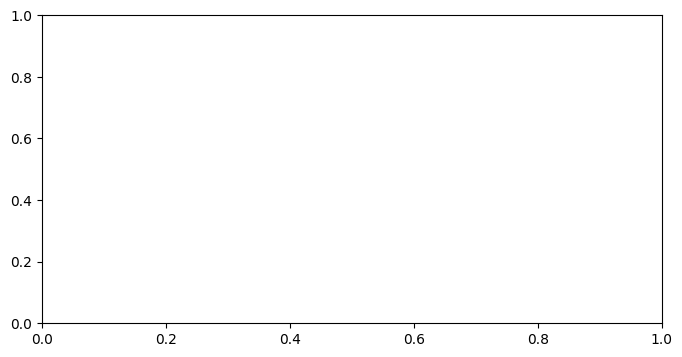

In [ ]:
if platform == 'notebook':
    %matplotlib inline

# clear the plot
plt.close()
px = 1/plt.rcParams['figure.dpi']  # pixel in inches
fig, ax = plt.subplots(figsize=(800*px, 400*px))
ax.plot(t, Vc_euler_charging,    label='Charging - Euler\'s',    linestyle='solid', linewidth=400*px)
ax.plot(t, Vc_exact_charging,    label='Charging - Exact',       linestyle='dashed', linewidth=400*px)
ax.plot(t, Vc_euler_discharging, label='Discharging - Euler\'s', linestyle='solid', linewidth=400*px)
ax.plot(t, Vc_exact_discharging, label='Discharging - Exact',    linestyle='dashed', linewidth=400*px, color='black')
# plot a line at Vs
ax.axhline(y=Vs, color='r', linestyle='--', label='Vs charging')
ax.set_xlabel('Time (ms)')
ax.set_ylabel(r'$V_C$ (V)')
ax.set_title(fr'RC Circuit Charging - $V_S={Vs} V$, $R={R} \Omega$, $C={C} F$')
ax.legend()
plt.grid()
plt.show()


---

>**Assignment 12**
>
> What can you say about the results given by Euler's method compared to the results from the exact solution?

Solution:

---

To get a <ins>better understanding</ins> of the charging and discharging of the RC circuit, you can use the **interactive plot** below. Modify the values of $V_S$, $R$, $C$ and observe, how the charing curve changes. Then, solve the **Assignments** below the **interactive plot**.

In [ ]:
from utils_ex1.utils import plot_vc_slider

if platform == 'notebook':
    %matplotlib inline
plt.close()
Vs_default = 5
R_default = 10000
C_default = 0.000001
V0_default = 0
plot_vc_slider(Vs_default, R_default, C_default, V0_default)

---

>**Assignment 13**
>
> What happens to the capacitor saturating voltage if you increase the voltage source $V_S$ (while keeping resistance $R$ and capacitance $C$ constant)?

Solution:

>**Assignment 14**
>
> What happens to the capacitor charging curve if you increase the resistance $R$ (while keeping capacitance $C$ and voltage source $V_S$ constant)?

Solution:

>**Assignment 15**
>
> What happens if you increase the capacitance $C$ (while keeping the resistance $R$ and the voltage source $V_S$ constant)?

Solution:

>**Assignment 16**
>
> Reset the plot by clicking the "Reset" button. Then, double the value for the capacitance and take a screenshot. Next, reset the plot, double the resistance value and take another screenshot. Compare both screenshots. What do you observe? Why?

Solution:

---

## 2.3: The time constant $\tau$ (tau) <a name="tau"></a>

In neurons, the **time constant $\tau$** refers to the <ins>time it takes</ins> for the membrane potential to either <ins>charge or discharge to approximately 63% of its final value</ins> after a change in input (such as the introduction of a current).

It is given by $\tau = RC$ and gives you an idea of how fast the capacitor charges or discharges.

<ins>Clarifying the relationship between the time constant and the previous exercise:</ins>

When you look at the discretized equation for our RC circuit above:

$V_C(t + \Delta t) = e^{-\frac{\Delta t}{R * C}} * V_C(t) + (1 - e^{-\frac{\Delta t}{R * C}}) * V$,

you can see that the term $\frac{1}{R * C}$ appears twice.


Taking the analytical solution for charging a capacitor:

$V_C(t) = V * (1 - e^{-t / (RC)})$,

you can see that the voltage across the capacitor at time $t = \tau = RC$ is equal to $V_C(t=\tau) = V * (1 - e^{-1}) = 0.63 * V$.

In [ ]:
from utils_ex1.utils import plot_vc_tc_slider

if platform == 'notebook':
    %matplotlib inline
plt.close()
plot_vc_tc_slider()

The model above now shows a horizontal line (red) at 63% of the maximum Voltage $V_S$, represented by the horizontal orange line. In addition, we plot a tangent line (green) to the charing curve $V_C$ at $t=0$.

---

>**Assignment 17**
>
> Varying $R$ and $C$, how is the insersect between the tangent line and $V_S$ related to the intersect between $V_C$ and $0.63*V_S$?

Solution:

>**Assignment 18**
>
> On the cell above change the value of `plot_vertical_tc` to `True` and run the cell. What do you observe? Does it correspond to your previous answer?

Solution:

---

# End of this exercise session